# exp9. Pneumonia diagnostic model

## 0. 들어가며

### 0.1 프로젝트 목표
***
실제 의료 영상 데이터를 활용해 진단 모델 설계를 실습해보며, data augmentation 기법을 이해한다.

의료영상 이미지의 특징
* 의료 영상 이미지는 개인 정보 보호 등의 이슈로 인해 데이터를 구하는 것이 쉽지 않습니다.
* 라벨링 작업 자체가 전문적 지식을 요하므로 데이터셋 구축 비용이 비쌉니다.
* 희귀질병을 다루는 경우 데이터를 입수하는 것 자체가 드문 일입니다.
* 음성/양성 데이터 간 imbalance가 심합니다. 학습에 주의가 필요합니다.
* 이미지만으로 진단이 쉽지 않아 다른 데이터와 결합해서 해석해야 할 수도 있습니다.

### 0.2 루브릭
***

|**평가문항**|**상세기준**|
|------------|-------------|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

## 1. 실험환경 Set-up

In [2]:
# 커널정보: base(Python 3.9.7)
import sys
sys.path.append('C:\\Users\\Helpe\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages') # 라이브러리 경로 오류

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join('D:/project/aiffel_exp/exp9_Pneumonia diagnostic model/data')
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

D:/project/aiffel_exp/exp9_Pneumonia diagnostic model/data


## 2. 데이터 준비하기

In [4]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# val 비율이 너무 적어서 비율 재조정
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
D:\project\aiffel_exp\exp9_Pneumonia diagnostic model\data\chest_xray\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
D:\project\aiffel_exp\exp9_Pneumonia diagnostic model\data\chest_xray\train\PNEUMONIA\person610_bacteria_2475.jpeg


In [7]:
# 파일 경로를 통해 정상 이미지와 폐렴 이미지 수 체크
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 라벨 데이터 만들어주는 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지 사이즈를 통일 시키고 gpu 메모리의 효율적 사용을 위해 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [13]:
# train 데이터셋과 validation 데이터 셋 제작
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
# 이미지 리사이즈, 라벨링 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [15]:
# 동일하게 test 데이터 셋 제작
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
'''
Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
'''
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds2 = prepare_for_training(train_ds)
val_ds2 = prepare_for_training(val_ds)

### 2.1 데이터 시각화

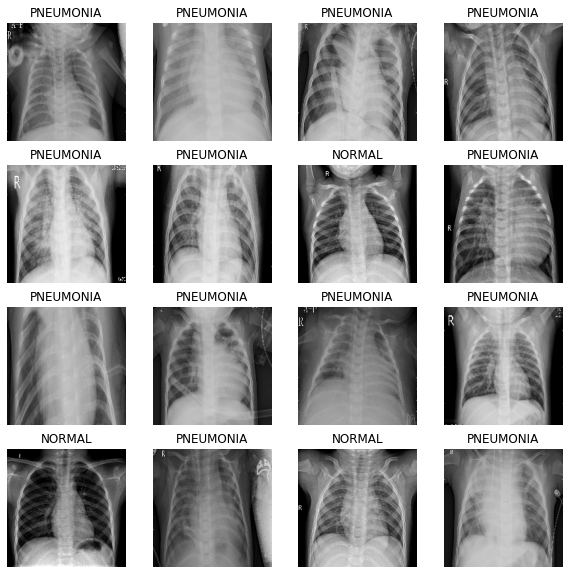

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds2))
show_batch(image_batch.numpy(), label_batch.numpy())

### 2.2 imagedatagenerator

In [16]:
# imagedatagenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = str(ROOT_PATH + '/chest_xray/train')
validation_data_dir = str(ROOT_PATH + '/chest_xray/val')
test_data_dir = str(ROOT_PATH + '/chest_xray/test')

In [17]:
img_width, img_height = 180, 180
epochs = 20
batch_size = 16

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 3. CNN 모델링

In [20]:
'''
먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 
Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다.
그리고 Max Pooling을 합니다.
'''
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [21]:
# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 4. 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.  

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다.  
Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.  
Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.  
상세한 내용은 아래 링크를 참고합시다.

딥러닝에서 클래스 불균형을 다루는 방법  
https://3months.tistory.com/414

In [23]:
'''
weight_for_0 = Normal 이미지에 사용할 weight
weight_for_1 = Pneumonia 이미지에 사용할 weight
weight들은 normal과 pneumonia 전체 데이터 건수에 반비례하도록 설정
'''

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 5. 모델훈련 & 평가 및 시각화

### 5.1 model1 (기본모델)

batch_size = 16  
optimizer = adam

In [23]:
'''
이미지 라벨이 두 개뿐이기 때문에 아래의 loss와 optimizer 사용 -> 두 개 뿐이라 왜?? 이유 찾아보기
loss = binary_cross entropy
optimizer = adam
'''

with tf.device('/GPU:0'):
    model1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model1.fit(
        train_ds2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 64s 199ms/step - loss: 0.3802 - accuracy: 0.8250 - precision: 0.9545 - recall: 0.8031 - val_loss: 0.7112 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 53s 204ms/step - loss: 0.2273 - accuracy: 0.9195 - precision: 0.9730 - recall: 0.9173 - val_loss: 1.0801 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 52s 200ms/step - loss: 0.2146 - accuracy: 0.9167 - precision: 0.9740 - recall: 0.9127 - val_loss: 0.1490 - val_accuracy: 0.9375 - val_precision: 0.9236 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 57s 220ms/step - loss: 0.1834 - accuracy: 0.9332 - precision: 0.9748 - recall: 0.9342 - val_loss: 0.7762 - val_accuracy: 0.7375 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 59s 227ms/step - loss: 0.1670 - accura

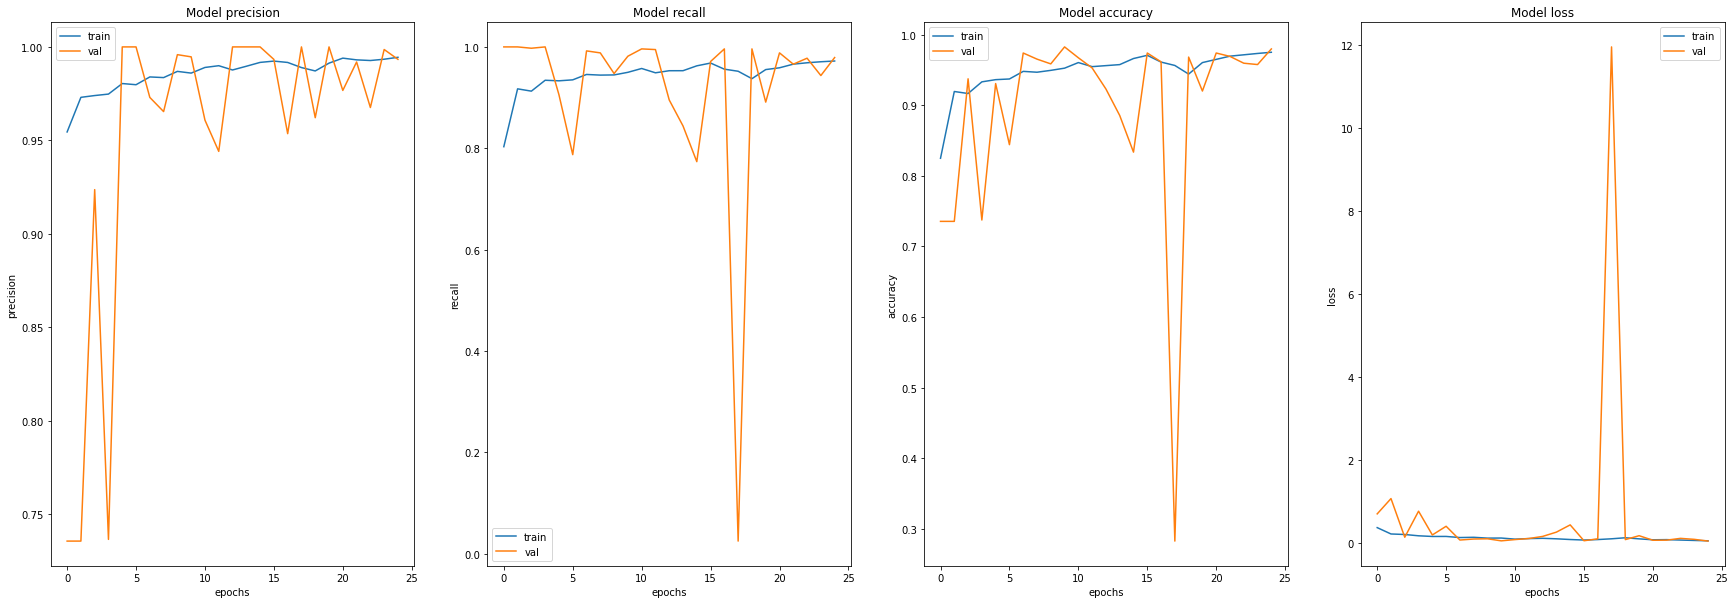

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
# test 데이터로 모델 평가 = loss, accuracy, precision, recall 값 출력
loss, accuracy, precision, recall = model1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 0.9822 - accuracy: 0.7885 - precision: 0.7500 - recall: 0.9923
Loss: 0.982229471206665,
Accuracy: 0.7884615659713745,
Precision: 0.75,
Recall: 0.9923076629638672


### 5.2 model2 (model1 + data augmentation)

In [27]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds3 = prepare_for_training(train_ds)
val_ds3 = prepare_for_training(val_ds)

In [28]:
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [29]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model2.fit(
        train_ds3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 60s 202ms/step - loss: 0.4510 - accuracy: 0.7732 - precision: 0.9395 - recall: 0.7435 - val_loss: 0.6133 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2390 - accuracy: 0.9064 - precision: 0.9758 - recall: 0.8964 - val_loss: 1.1133 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2224 - accuracy: 0.9136 - precision: 0.9731 - recall: 0.9089 - val_loss: 0.8985 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1910 - accuracy: 0.9239 - precision: 0.9733 - recall: 0.9233 - val_loss: 0.1093 - val_accuracy: 0.9606 - val_precision: 0.9712 - val_recall: 0.9751
Epoch 5/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1755 - accura

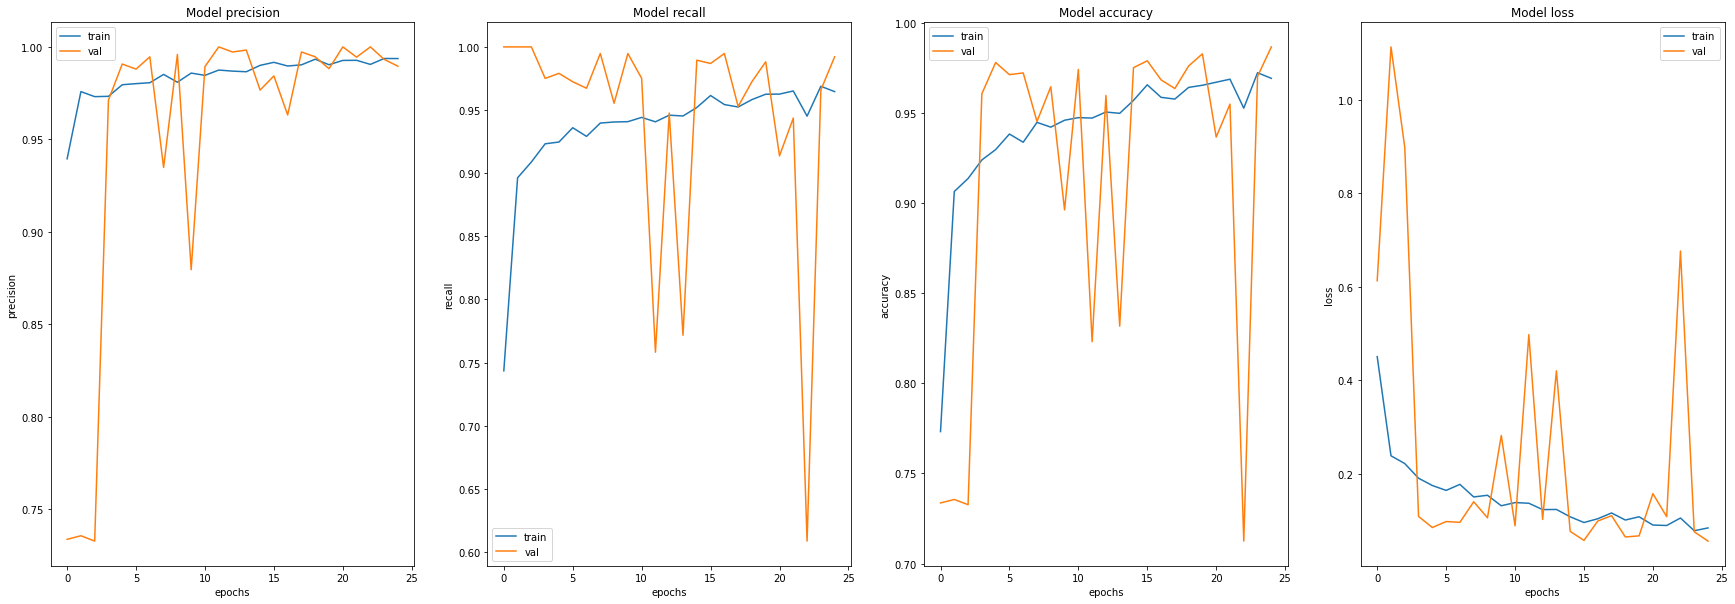

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
# test 데이터로 모델 평가 = loss, accuracy, precision, recall 값 출력
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 86ms/step - loss: 1.1119 - accuracy: 0.7532 - precision: 0.7193 - recall: 0.9923
Loss: 1.1118520498275757,
Accuracy: 0.7532051205635071,
Precision: 0.7193308472633362,
Recall: 0.9923076629638672


### 5.3 model3 (imagedatagenerator)

In [32]:
BATCH_SIZE = 32
EPOCHS = 25

with tf.device('/GPU:0'):
    model3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [33]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model3.fit(
        train_generator,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 38s 273ms/step - loss: 0.5325 - accuracy: 0.7279 - precision: 0.9165 - recall: 0.6969 - val_loss: 0.7610 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 34s 260ms/step - loss: 0.4187 - accuracy: 0.8173 - precision: 0.9388 - recall: 0.8061
Epoch 3/25
130/130 [==============================] - 35s 270ms/step - loss: 0.3427 - accuracy: 0.8495 - precision: 0.9572 - recall: 0.8328
Epoch 4/25
130/130 [==============================] - 33s 256ms/step - loss: 0.3201 - accuracy: 0.8625 - precision: 0.9541 - recall: 0.8569
Epoch 5/25
130/130 [==============================] - 33s 255ms/step - loss: 0.2792 - accuracy: 0.8913 - precision: 0.9674 - recall: 0.8834
Epoch 6/25
130/130 [==============================] - 31s 237ms/step - loss: 0.2913 - accuracy: 0.8827 - precision: 0.9648 - recall: 0.87875s - loss: 0.2969 - accuracy: 0.8833 - precisio
Epoch 7/25
130/130 [======

#### `WARNING:tensorflow:Your input ran out of data; interrupting training.`

`ImageDataGenerator`로 데이터셋을 생성하고 모델을 훈련하자 오류가 뜨면서 validation에 대한 결과가 출력되지 않는다.  
구글링을 해보니 데이터 수에 비해 너무 많은 step을 설정해서 라는데, 오류창에서 제안하는 batch로 설정해도 계속 오류가 발생했다.  

검색을 통해 나와 같은 케이스에 해결한 사례를 찾았고   
결론은 `keras`와 `tensorflow`의 버전 호환 문제로 발생한 오류였으며, 버전 다운그레이드를 통해 해결했다는 정보를 얻었다.  

해결법은 알았으나 나의 경우 처음 로컬 환경을 구축할 때 아무런 지식없이 설치 - 삭제를 반복하여 라이브러리 경로가 약 3군데(추정)로 퍼져있고
`pip`명령어를 통해 uninstall 후 호환 버전으로 install해도 다른 경로에 있는 라이브러리를 불러와서 호환되는 버전으로 실행을 못했다.

경로 정리 및 가상환경으로 처음부터 실행하는 방법도 있으나 시간 부족으로 인해  
ImageDataGenerator를 사용한 model의 validation 시각화를 포기했다.

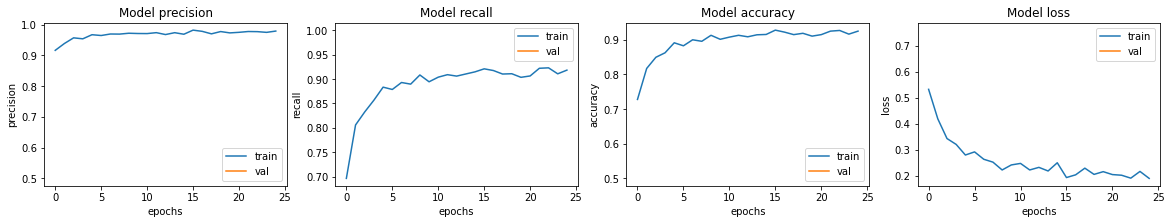

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 83ms/step - loss: 0.7100 - accuracy: 0.8526 - precision: 0.8117 - recall: 0.9949
Loss: 0.7100476026535034,
Accuracy: 0.8525640964508057,
Precision: 0.8117154836654663,
Recall: 0.9948717951774597


### 5.4 model4 (model3 + optimizer)

In [28]:
BATCH_SIZE = 32
EPOCHS = 40

with tf.device('/GPU:0'):
    model4= build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model4.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
# 모델 fit
with tf.device('/GPU:0'):
    history = model4.fit(
        train_generator,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
130/130 [==============================] - 41s 266ms/step - loss: 0.5312 - accuracy: 0.7337 - precision: 0.9165 - recall: 0.6995 - val_loss: 0.7971 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/40
130/130 [==============================] - 37s 282ms/step - loss: 0.4262 - accuracy: 0.8197 - precision: 0.9389 - recall: 0.8040
Epoch 3/40
130/130 [==============================] - 35s 263ms/step - loss: 0.3476 - accuracy: 0.8601 - precision: 0.9580 - recall: 0.8502
Epoch 4/40
130/130 [==============================] - 35s 268ms/step - loss: 0.3370 - accuracy: 0.8668 - precision: 0.9611 - recall: 0.8596
Epoch 5/40
130/130 [==============================] - 35s 266ms/step - loss: 0.3047 - accuracy: 0.8788 - precision: 0.9556 - recall: 0.8776
Epoch 6/40
130/130 [==============================] - 35s 271ms/step - loss: 0.2753 - accuracy: 0.8923 - precision: 0.9646 - recall: 0.8868
Epoch 7/40
130/130 [==============================] - 35s 269ms/step - lo

In [27]:
loss, accuracy, precision, recall = model4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 82ms/step - loss: 0.3767 - accuracy: 0.8830 - precision: 0.8514 - recall: 0.9846
Loss: 0.37665608525276184,
Accuracy: 0.8830128312110901,
Precision: 0.8514412641525269,
Recall: 0.9846153855323792


## 6. 정리

1. **model1 (기본)**
   * batch = 16
   * optimizer = adam
   * data augmentation = x
   * accuracy = 0.79
   * recall = 0.99
2. **model2 (model1 + data augmentation)**
   * batch = 16
   * optimizer = adam
   * data augmentation = baseline
   * accuracy = 0.75
   * recall = 0.99
3. **model3 (batch 변경 + imagedatageneration)**
   * batch = 32
   * optimizer = adam
   * data augmentation = imagedatagenerator
   * accuracy = 0.85
   * recall = 0.99
4. **model4 (model3 + optimizer 변경)**
   * batch = 32
   * optimizer = rmsprop
   * data augmentation = imagedatagenerator
   * accuracy = 0.88
   * recall = 0.98

## 7. 느낀점
***
* 의료영상 데이터의 특징에 관한 설명과 실제 데이터셋을 통해 모델설계, 진단 정확도 등을 구현하는 과정이 재밌었다. 확실히 필드데이터를 정해진 규격내에서 수집이 가능한 분야라면 인공지능이 전문인력을 대체 가능함을 느꼈다.
* 데이터 증강에 대한 소개와 과정을 따라해 볼 수 있어서 유익했으나, 관련 코드 및 세부내용을 명확하게 이해하진 못해서 아쉽다.
* 베이스라인에서 제공하는 코드가 기존 exp에서 진행된 스타일과 달라서 많이 헷갈렸다. 코드의 형태가 달라지자 바로 어색해지는 걸 보니 코딩관련 지식이 여전히 많이 부족함을 느낀다.
* exp를 진행할수록 여러 모델을 시험하고 정확도를 기록해야 할 때 해당 과정을 세련되게 진행하는 방법에 대한 갈증이 커진다.